In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 0. Загрузить данные

In [2]:
def init_full_dataset(dates_range):
    dates = []
    dataset = []
    for date in dates_range:
        file =f'{name}_{date}.npy'
        array = np.load(f'./kara/{file}')
        dates.append(date)
        dataset.append(array)
    return dates, np.array(dataset)

In [3]:
name = 'osi_masie'
all_dates, all_matrices = init_full_dataset(pd.date_range('20060101', '20240831').strftime('%Y%m%d'))

In [4]:
def createDataset(data, history_steps, forecast_steps, between_data_steps=1):
    data = data[::between_data_steps].copy()
    x_data = []
    y_data = []
    for i in range(len(data) - history_steps - forecast_steps):
        x = data[i:i+history_steps]
        y = data[i+history_steps:i+history_steps+forecast_steps]
        x = np.expand_dims(x, axis=1) 
        y = np.expand_dims(y, axis=1)
        x_data.append(x)
        y_data.append(y)
    return (x_data), (y_data)

In [5]:
X, Y = createDataset(data=all_matrices, history_steps=5*3, forecast_steps=1, between_data_steps=7)

# 1. Создание модели

In [6]:
class LSTMConv2DModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, lstm_hidden_size, output_channels=1, output_steps=1):
        super(LSTMConv2DModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_channels * 140 * 120, hidden_size=lstm_hidden_size, batch_first=True)
        self.conv1 = nn.Conv2d(in_channels=output_channels, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_dim, out_channels=output_channels, kernel_size=3, padding=1)
        self.fc = nn.Linear(lstm_hidden_size, output_steps * output_channels * 140 * 120)
        self.output_steps = output_steps  

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.size()
        x = x.view(batch_size, time_steps, -1)  
        x, _ = self.lstm(x) 
        x = x[:, -1, :] 
        x = self.fc(x)  
        x = x.view(batch_size, self.output_steps, 1, 140, 120)
        output = []
        
        for i in range(self.output_steps):
            conv_out = self.conv1(x[:, i, :, :, :]) 
            conv_out = torch.relu(conv_out)
            conv_out = self.conv2(conv_out)
            output.append(conv_out)

        output = torch.stack(output, dim=1)  
        return output

# 3. Обучение

In [7]:
X_train, Y_train = X[:-100], Y[:-100]
X_test, Y_test = X[-100:], Y[-100:]

In [8]:
X_train = torch.Tensor(X_train)  
Y_train = torch.Tensor(Y_train)  
X_test = torch.Tensor(X_test) 
Y_test = torch.Tensor(Y_test) 

C:\Users\User\AppData\Local\Temp\ipykernel_19420\2870724454.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train = torch.Tensor(X_train)


In [9]:
dataset_train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=4)
dataset_test = TensorDataset(X_test, Y_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [10]:
#train_loader_without_shifle = DataLoader(dataset_train, batch_size=1, shuffle=False, num_workers=4)

In [11]:
input_channels = 1  
hidden_dim = 64
lstm_hidden_size = 32
output_channels = 1  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMConv2DModel(input_channels, hidden_dim, lstm_hidden_size, output_channels).to(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [14]:
num_epochs = 1000
data_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    data_loss.append(running_loss/len(train_loader))   
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

print('Обучение завершено.')

Epoch 1/1000, Loss: 0.023090386208410578
Epoch 2/1000, Loss: 0.02388574497478185
Epoch 3/1000, Loss: 0.02474830116309217
Epoch 4/1000, Loss: 0.02252716244790499
Epoch 5/1000, Loss: 0.02270232505887684
Epoch 6/1000, Loss: 0.02513979872098298
Epoch 7/1000, Loss: 0.02083072556513264
Epoch 8/1000, Loss: 0.021815568816143636
Epoch 9/1000, Loss: 0.021164753196384088
Epoch 10/1000, Loss: 0.02131604584338825
Epoch 11/1000, Loss: 0.020236020189627738
Epoch 12/1000, Loss: 0.020206656624681896
Epoch 13/1000, Loss: 0.019164236980810052
Epoch 14/1000, Loss: 0.019729811068429418
Epoch 15/1000, Loss: 0.020278172426004156
Epoch 16/1000, Loss: 0.019718738406093894
Epoch 17/1000, Loss: 0.02063468680096305
Epoch 18/1000, Loss: 0.021234239483845643
Epoch 19/1000, Loss: 0.019024873813554548
Epoch 20/1000, Loss: 0.01991474994179838
Epoch 21/1000, Loss: 0.020347352252810723
Epoch 22/1000, Loss: 0.01906389277387684
Epoch 23/1000, Loss: 0.01804781698743652
Epoch 24/1000, Loss: 0.01869622557021711
Epoch 25/1000

Text(0, 0.5, 'MSE')

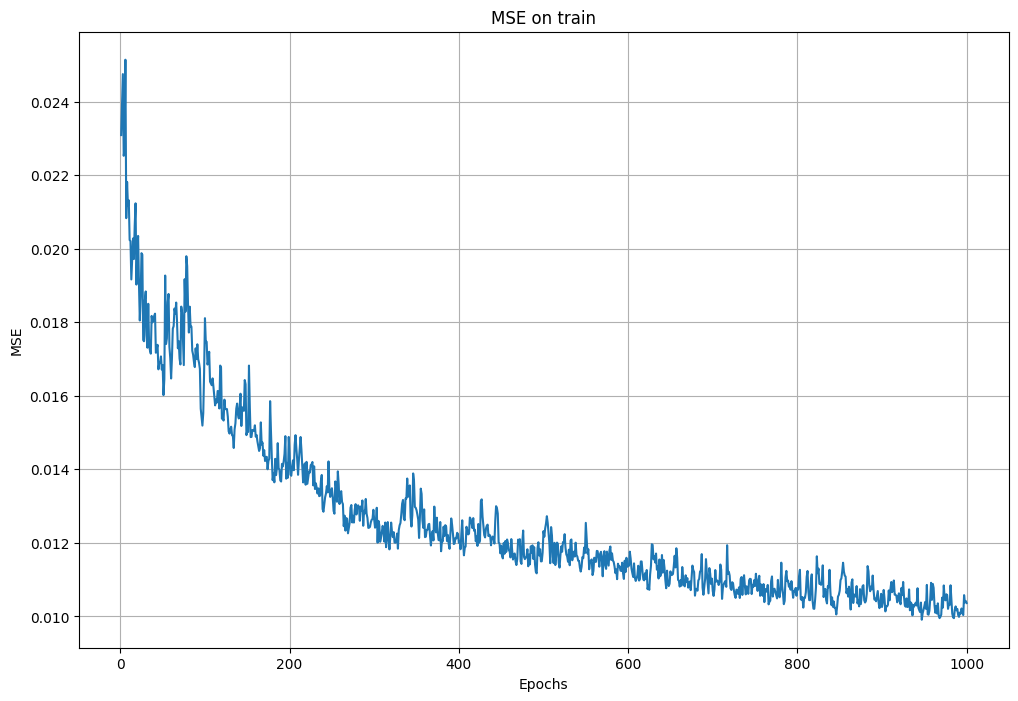

In [16]:
plt.figure(figsize=(12,8))
plt.title('MSE on train')
plt.plot([i for i in range(1,1001)], data_loss, label='MSE_loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [17]:
torch.save(model.state_dict(), 'model.pth')

# Предсказание

In [18]:
model.eval()
data_predict = []
data_real = []
with torch.no_grad():
    total_loss = 0
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        predict = model(inputs)
        data_predict.append(predict)
        data_real.append(targets)
        loss = criterion(predict, targets)
        total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {avg_loss}')

Average Test Loss: 0.021519187637604773


In [19]:
data_predict = [data_predict[i][0][0][0].cpu().detach().numpy() for i in range(len(data_predict))]

In [20]:
data_real = [data_real[i][0][0][0].cpu().detach().numpy() for i in range(len(data_real))]

# Визуализация

In [22]:
def save_gif(
    matrices,
    name: str,
    writer: str = "pillow",
    fps: int = 2,
    interval: int = 10000,
) -> None:
    """
    Saving matrices lika a .gif file

    :param matrices: array of frames
    :param name: filename
    :param writer: writer of frames. Default: pillow
    :param fps: fps. Default: 30
    :param interval: interval between frames in milliseconds. Default: 10
    """
    fig, ax = plt.subplots()
    frames = list(map(lambda x: (ax.imshow(1 - x, cmap='Blues_r'),), matrices))
    ani = animation.ArtistAnimation(fig=fig, artists=frames, interval=interval)
    ani.save(filename=f"{name}.gif", writer=writer, fps=fps)

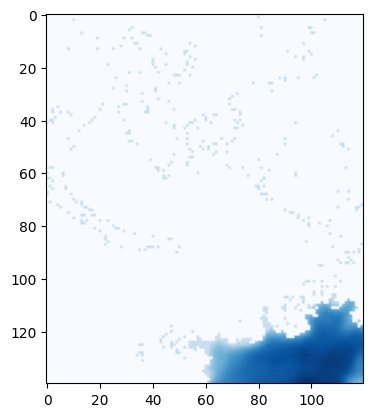

In [23]:
save_gif(data_real, 'real_animation')

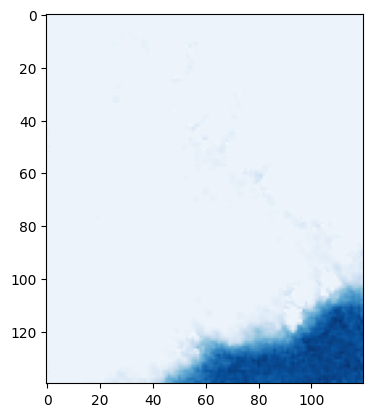

In [24]:
save_gif(data_predict, 'predict_animation')

# Обработка изображения

In [152]:
from copy import deepcopy
from scipy import interpolate
from scipy.ndimage import gaussian_filter

In [153]:
def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )
    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

def return_interpolated_field(image):
    image[image == 0] = np.nan
    mask = np.isnan(image)
    image_smoothed = interpolate_missing_pixels(image, mask, 'nearest')
    image_smoothed = gaussian_filter(image_smoothed, sigma=2.5)
    image[np.isnan(image)] = image_smoothed[np.isnan(image)]
    return image

def gradate(raw_array):
    array = deepcopy(raw_array)
    array[np.where((array > 0.9))] = 9
    array[np.where((array > 0.8) & (array <= 0.9))] = 8
    array[np.where((array > 0.7) & (array <= 0.8))] = 7
    array[np.where((array > 0.6) & (array <= 0.7))] = 6
    array[np.where((array > 0.4) & (array <= 0.6))] = 4
    array[np.where((array > 0.3) & (array <= 0.4))] = 3
    array[np.where((array > 0.2) & (array <= 0.3))] = 2
    array[np.where((array > 0.1) & (array <= 0.2))] = 1
    array[array <= 0.1] = 0
    return array

# Ошибки

In [35]:
from skimage.metrics import structural_similarity

In [36]:
def mae(prediction, real):
    return round(float(np.mean(abs(np.array(prediction) - np.array(real)))), 3)

def ssim(prediction, real):
    return round(structural_similarity(prediction, real, data_range=1), 3)

In [56]:
mae_in_test = []
ssim_in_test = []

for i in range(len(data_predict)):
    mae_in_test.append(mae(data_predict[i], data_real[i]))
    ssim_in_test.append(ssim(data_predict[i], data_real[i]))

Text(0.5, 0, 'MAE')

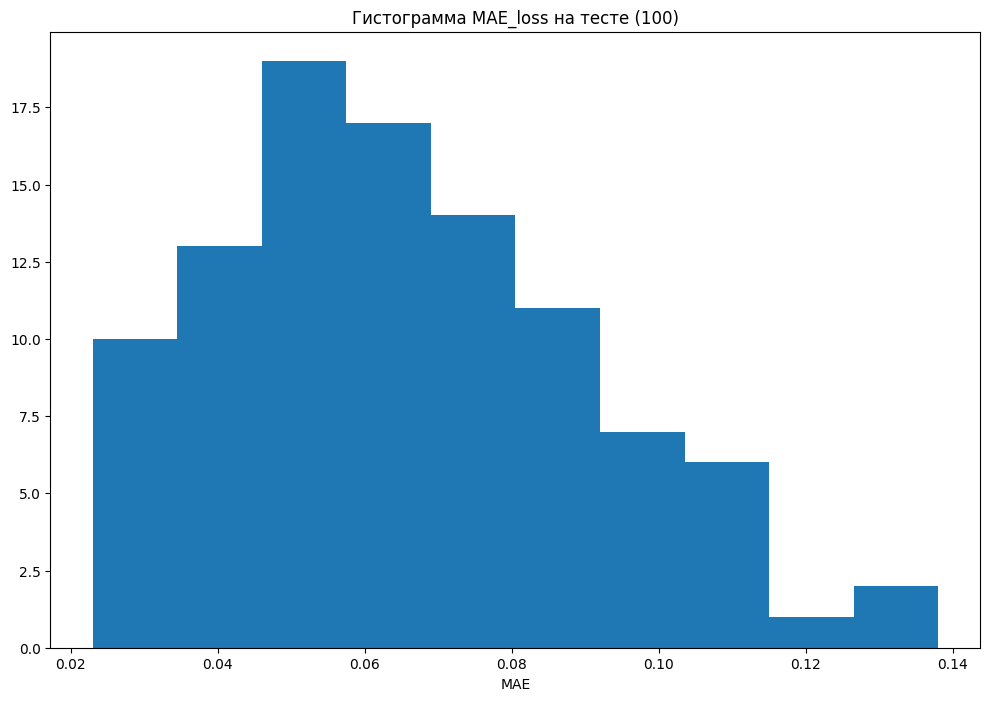

In [57]:
plt.figure(figsize=(12,8))
plt.hist(mae_in_test,)
plt.title('Гистограмма MAE_loss на тесте (100)')
plt.xlabel('MAE')

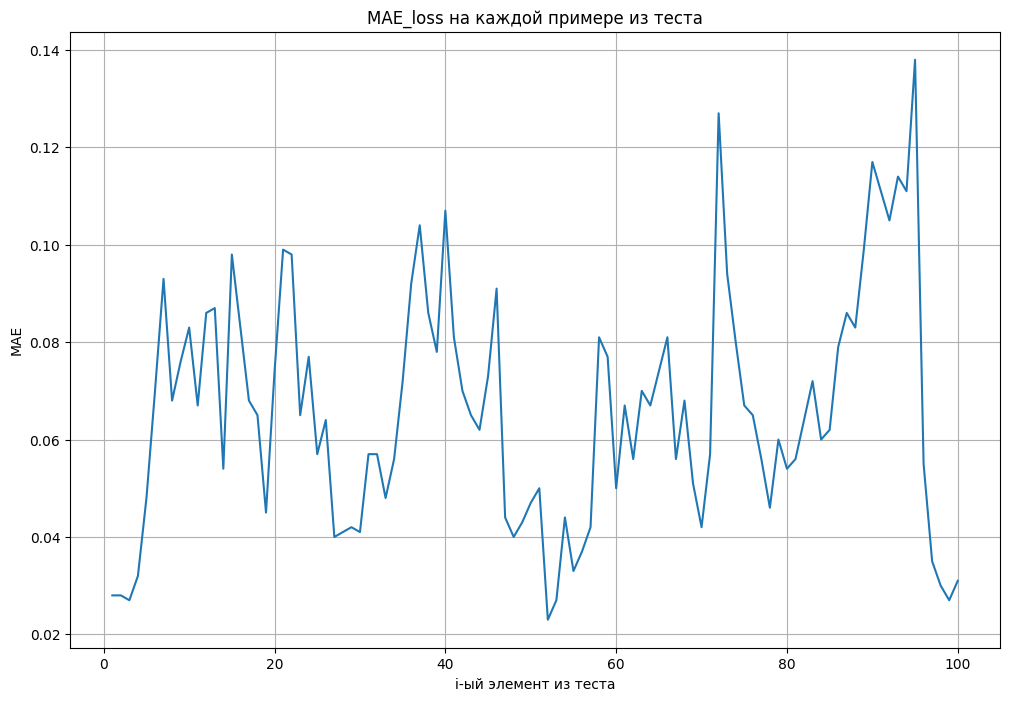

In [61]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(1,101)], mae_in_test,)
plt.title('MAE_loss на каждой примере из теста')
plt.xlabel('i-ый элемент из теста')
plt.ylabel('MAE')
plt.grid()

Text(0.5, 0, 'SSIM')

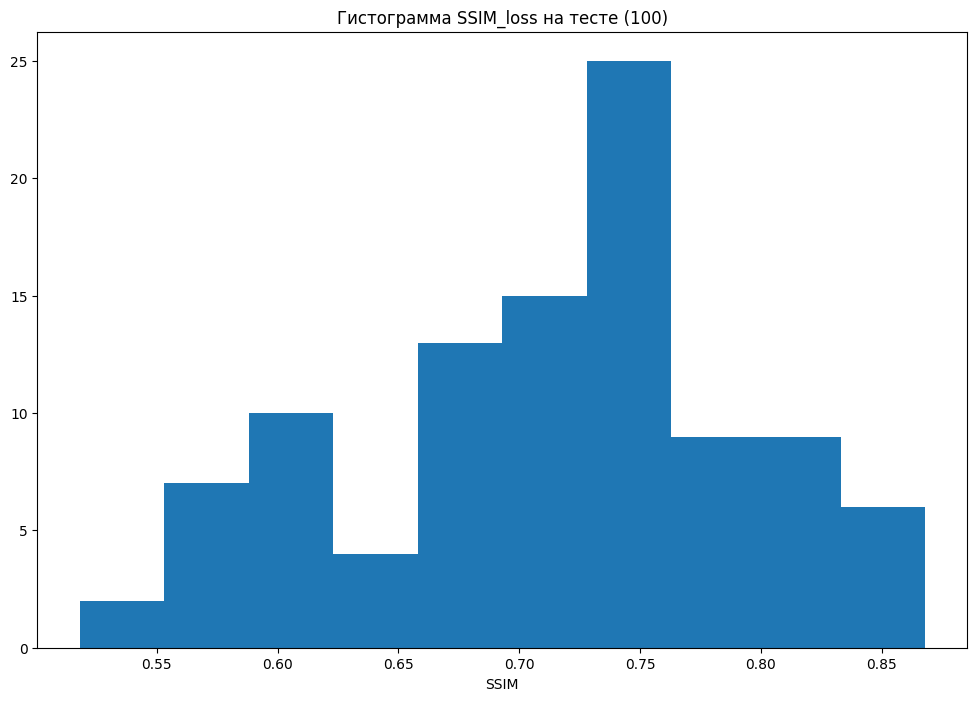

In [58]:
plt.figure(figsize=(12,8))
plt.hist(ssim_in_test,)
plt.title('Гистограмма SSIM_loss на тесте (100)')
plt.xlabel('SSIM')

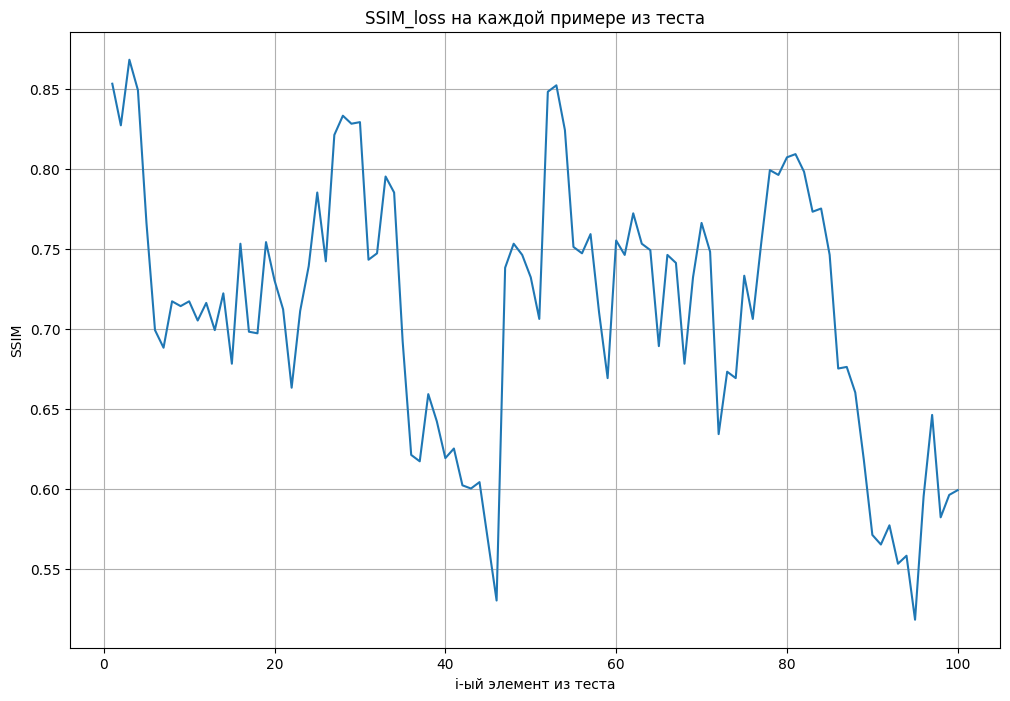

In [62]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(1,101)], ssim_in_test,)
plt.title('SSIM_loss на каждой примере из теста')
plt.xlabel('i-ый элемент из теста')
plt.ylabel('SSIM')
plt.grid()

# Вывод

1. Сделан прогноз концентрации льда на неделю вперед (7 дней), учитывай предысторию 15 недель (7*15 дней). Прогнозируется только 1 изображение.
2. Результаты получены "не плохие", возможно потому что у прогнозе участвет изображение неделю назад
3. При увеличении шага между данными, остальные данные "выкидывались" и никак дальше не участвовали в прогнозе.
4. Данные никак не обрабатывались

# Реальные данные

![Предсказание](./predict_animation.gif)


# Предсказание

![Реальные данные](./predict_animation.gif)
